## Importing Libraries

In [8]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## Paths to dataset folders

In [9]:
base_dir = "D:\\Project 2\\chest_xray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")


## Data Analysis

In [10]:
# Helper function to count images in each class
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Count images in train, val, and test sets
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

Class Distribution in Training Set: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Class Distribution in Validation Set: {'NORMAL': 8, 'PNEUMONIA': 8}
Class Distribution in Test Set: {'NORMAL': 234, 'PNEUMONIA': 390}


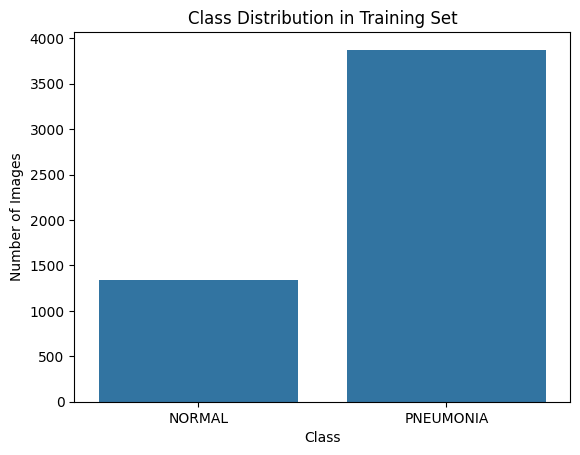

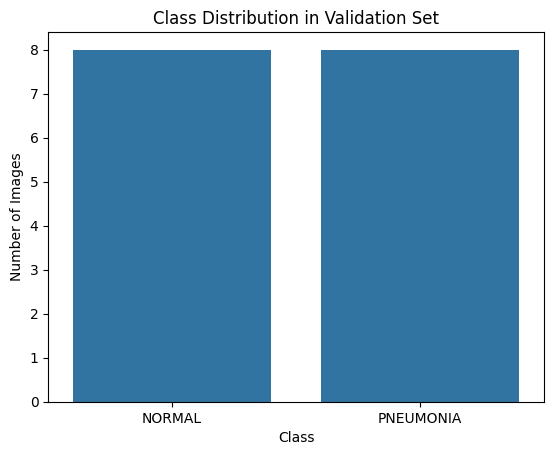

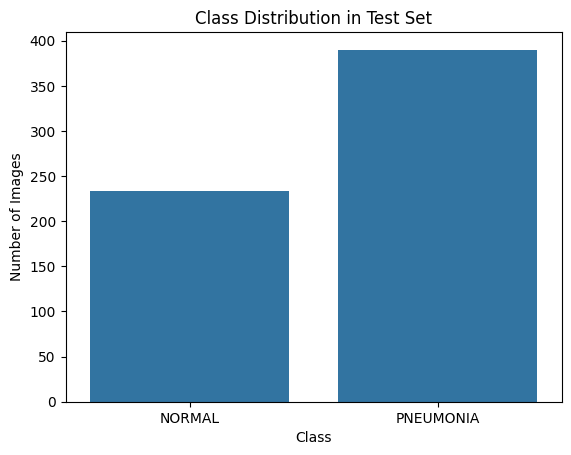

In [11]:
# Plot class distributions
def plot_class_distribution(data, title):
    sns.barplot(x=list(data.keys()), y=list(data.values()))
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.show()

print("Class Distribution in Training Set:", train_counts)
print("Class Distribution in Validation Set:", val_counts)
print("Class Distribution in Test Set:", test_counts)

plot_class_distribution(train_counts, "Class Distribution in Training Set")
plot_class_distribution(val_counts, "Class Distribution in Validation Set")
plot_class_distribution(test_counts, "Class Distribution in Test Set")

## Analyze image properties

In [12]:
def analyze_image_properties(directory):
    image_shapes = []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = Image.open(img_path)
                image_shapes.append(img.size)  # Width x Height
    return image_shapes

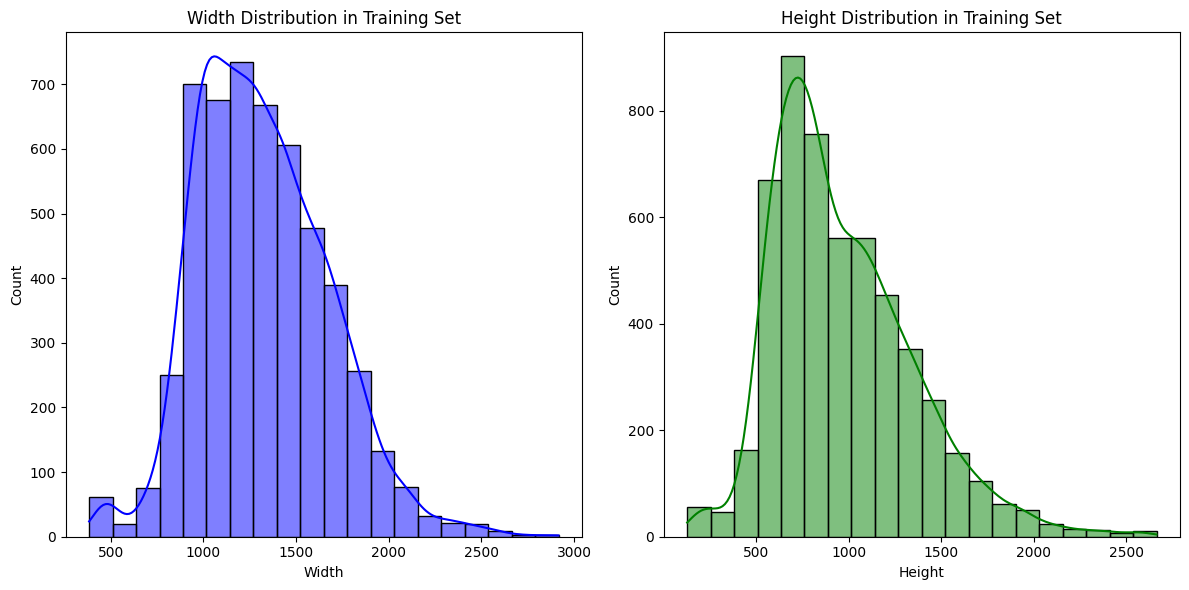

In [13]:
# Get image properties for training set
train_image_shapes = analyze_image_properties(train_dir)
widths, heights = zip(*train_image_shapes)

# Plot image width and height distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=20, kde=True, color='blue')
plt.title("Width Distribution in Training Set")
plt.xlabel("Width")

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=20, kde=True, color='green')
plt.title("Height Distribution in Training Set")
plt.xlabel("Height")

plt.tight_layout()
plt.show()

In [14]:
# Calculate mean, median, and mode of dimensions
print("Mean Image Width:", np.mean(widths))
print("Mean Image Height:", np.mean(heights))
print("Median Image Width:", np.median(widths))
print("Median Image Height:", np.median(heights))
print("Most Common Width and Height:", Counter(train_image_shapes).most_common(1))

Mean Image Width: 1320.6108128834355
Mean Image Height: 968.0747699386503
Median Image Width: 1284.0
Median Image Height: 888.0
Most Common Width and Height: [((1072, 648), 7)]


## Data Augmentation

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,               # Normalize pixel values to [0, 1]
    rotation_range=20,               # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,           # Shift width randomly by up to 20%
    height_shift_range=0.2,          # Shift height randomly by up to 20%
    shear_range=0.2,                 # Apply random shearing
    zoom_range=0.2,                  # Apply random zoom
    horizontal_flip=True             # Randomly flip images horizontally
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Only normalize for validation
test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Only normalize for testing




## Load images from directories

In [18]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize all images to 150x150
    batch_size=32,
    class_mode='binary'      # For binary classification: NORMAL vs PNEUMONIA
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


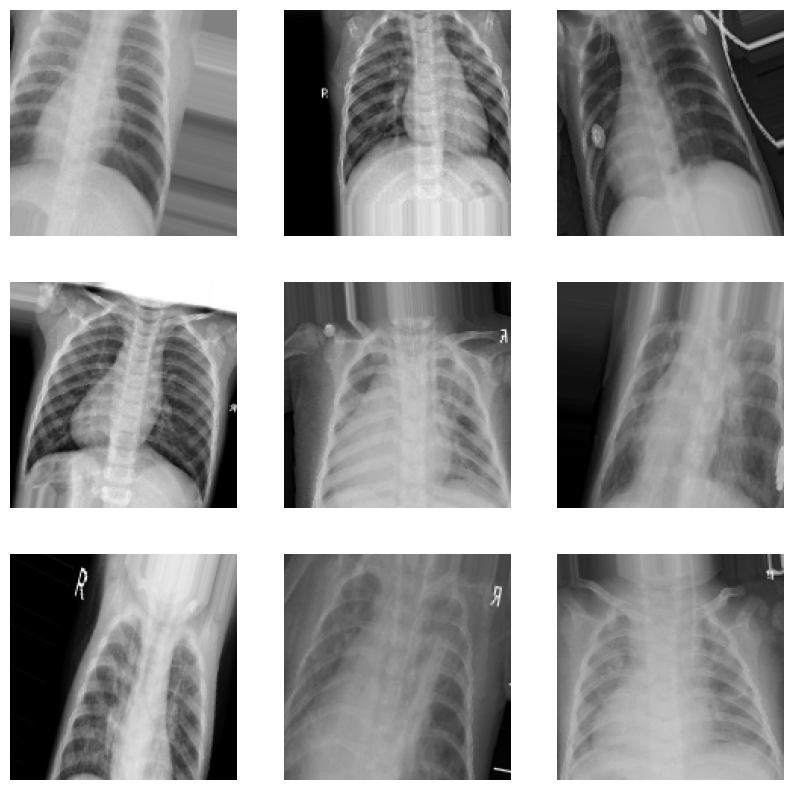

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels from train_generator
images, labels = next(train_generator)

# Plot some augmented images
plt.figure(figsize=(10, 10))
for i in range(9):  # Display 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])  # Show image
    plt.axis('off')  # Hide axes
plt.show()

## Defining CNN Model

In [62]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

C:\Users\adars\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Compiling the Model

In [63]:
# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Training the Model

In [64]:
# Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1
)

C:\Users\adars\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 615ms/step - accuracy: 0.7437 - loss: 0.5554 - val_accuracy: 0.6875 - val_loss: 0.6733
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 609ms/step - accuracy: 0.8481 - loss: 0.3420 - val_accuracy: 0.7500 - val_loss: 0.5670
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 622ms/step - accuracy: 0.8693 - loss: 0.2985 - val_accuracy: 0.8125 - val_loss: 0.4893
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 626ms/step - accuracy: 0.8869 - loss: 0.2609 - val_accuracy: 0.8125 - val_loss: 0.7902
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 627ms/step - accuracy: 0.8894 - loss: 0.2530 - val_accuracy: 0.7500 - val_loss: 0.4120
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 637ms/step - accuracy: 0.8815 - loss: 0.2612 - val_accuracy: 0.8125 - val_loss: 0.5503
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 645ms/step - accuracy: 0.9039 - loss: 0.2214 - val_accuracy: 0.8750 - val_loss: 0.6760
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 646ms/step - accuracy: 0.9081 - 

## Saving the Model

In [65]:
model.save('pneumonia_CNN_model.h5')  # Save the trained model
print("Model saved as 'pneumonia_cnn_model.h5'")


Model saved as 'pneumonia_cnn_model.h5'


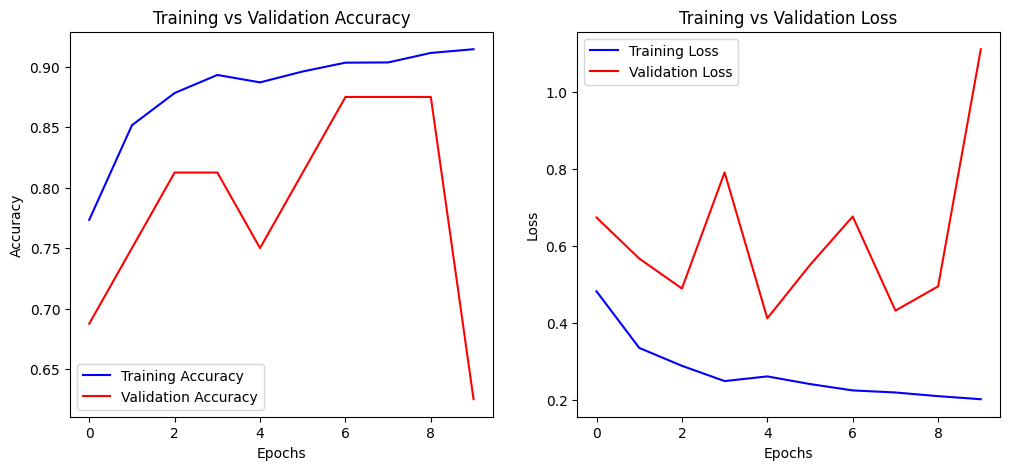

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step


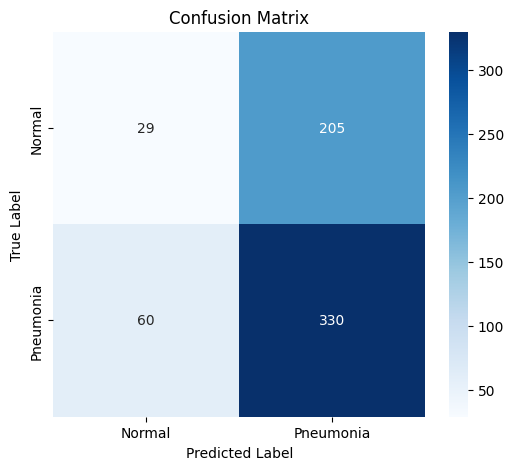

Classification Report:
               precision    recall  f1-score   support

      Normal       0.33      0.12      0.18       234
   Pneumonia       0.62      0.85      0.71       390

    accuracy                           0.58       624
   macro avg       0.47      0.49      0.45       624
weighted avg       0.51      0.58      0.51       624

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 322ms/step


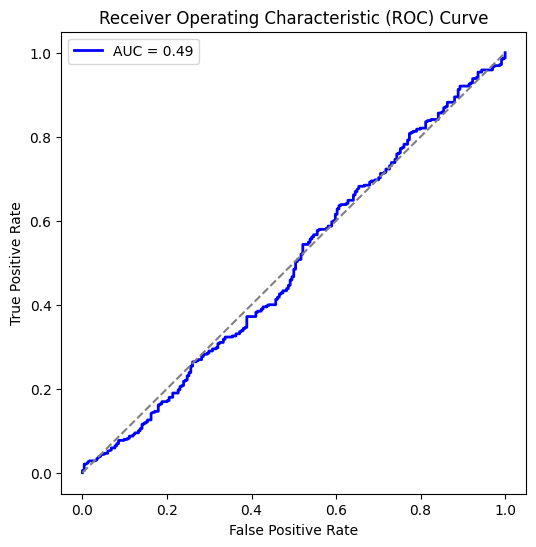

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Function to plot Accuracy and Loss Curves
def plot_training_history(history):
    epochs = range(len(history.history['accuracy']))

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'b-', label="Training Accuracy")
    plt.plot(epochs, history.history['val_accuracy'], 'r-', label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'b-', label="Training Loss")
    plt.plot(epochs, history.history['val_loss'], 'r-', label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    plt.show()

plot_training_history(history)


# Generate Confusion Matrix
y_true = test_generator.classes  # True labels from test set
y_pred = (model.predict(test_generator) > 0.5).astype("int32")  # Convert probabilities to 0 or 1

cm = confusion_matrix(y_true, y_pred)
class_labels = ["Normal", "Pneumonia"]  # Modify based on your class labels

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))


# Plot ROC Curve
y_prob = model.predict(test_generator)  # Get probability scores
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label="AUC = {:.2f}".format(roc_auc))
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()


## Evaluate on Test Set

In [67]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 323ms/step - accuracy: 0.7614 - loss: 0.5724
Test Accuracy: 75.48%


## Creating base model

In [68]:
# Function to create a base model
def create_base_model(base_model, name):
    base = base_model(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base.trainable = False  # Freeze base model layers
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base.input, outputs=output, name=name)
    return model

## Define Models

In [69]:
from tensorflow.keras.applications import ResNet50, DenseNet121, VGG16, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [70]:
models = {
    "ResNet50": create_base_model(ResNet50, "ResNet50"),
    "DenseNet121": create_base_model(DenseNet121, "DenseNet121"),
    "VGG16": create_base_model(VGG16, "VGG16"),
    "EfficientNetB0": create_base_model(EfficientNetB0, "EfficientNetB0")
}

## Train Each Model Separately

In [71]:
history_dict = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...\n")
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(train_generator, epochs=10, validation_data=val_generator)
    
    # Save training history
    history_dict[model_name] = history
    
    # Save the model
    model.save(f"{model_name}.h5")
    print(f"✅ {model_name} Trained and Saved Successfully!\n")


Training ResNet50...

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 167s 979ms/step - accuracy: 0.7149 - loss: 0.6014 - val_accuracy: 0.5000 - val_loss: 0.8209
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 156s 954ms/step - accuracy: 0.7295 - loss: 0.5910 - val_accuracy: 0.5000 - val_loss: 0.8738
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 163s 997ms/step - accuracy: 0.7476 - loss: 0.5563 - val_accuracy: 0.5000 - val_loss: 0.7670
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 152s 935ms/step - accuracy: 0.7541 - loss: 0.5354 - val_accuracy: 0.5000 - val_loss: 0.7710
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 149s 913ms/step - accuracy: 0.7396 - loss: 0.5402 - val_accuracy: 0.5000 - val_loss: 0.8290
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 155s 951ms/step - accuracy: 0.7364 - loss: 0.5353 - val_accuracy: 0.5000 - val_loss: 0.7982
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 157s 963ms/step - accuracy: 0.7405 - loss: 0.5264 - val_accuracy: 0.5000 - val_loss: 0.7654
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 154s 942ms/st

✅ ResNet50 Trained and Saved Successfully!


Training DenseNet121...

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.7327 - loss: 0.5642 - val_accuracy: 0.8125 - val_loss: 0.4451
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 162s 995ms/step - accuracy: 0.8814 - loss: 0.2825 - val_accuracy: 0.8125 - val_loss: 0.4853
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 159s 978ms/step - accuracy: 0.8985 - loss: 0.2435 - val_accuracy: 0.8750 - val_loss: 0.3971
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 159s 976ms/step - accuracy: 0.9096 - loss: 0.2178 - val_accuracy: 0.8750 - val_loss: 0.5121
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 162s 995ms/step - accuracy: 0.9096 - loss: 0.2139 - val_accuracy: 0.8750 - val_loss: 0.4688
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 157s 962ms/step - accuracy: 0.9176 - loss: 0.2019 - val_accuracy: 0.8750 - val_loss: 0.4102
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 156s 954ms/step - accuracy: 0.9326 - loss: 0.1761 - val_accuracy: 0.8750 - val_loss: 0.4900
Epoch 8/1

✅ DenseNet121 Trained and Saved Successfully!


Training VGG16...

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.7122 - loss: 0.5815 - val_accuracy: 0.5000 - val_loss: 0.6661
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.7461 - loss: 0.4852 - val_accuracy: 0.6875 - val_loss: 0.5541
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.7987 - loss: 0.4117 - val_accuracy: 0.7500 - val_loss: 0.4642
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.8232 - loss: 0.3741 - val_accuracy: 0.7500 - val_loss: 0.4318
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.8632 - loss: 0.3312 - val_accuracy: 0.8125 - val_loss: 0.3977
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.8707 - loss: 0.3114 - val_accuracy: 0.8125 - val_loss: 0.3782
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.8720 - loss: 0.2939 - val_accuracy: 0.8125 - val_loss: 0.3576
Epoch 8/10
163/163 ━━━━━━━━━━━

✅ VGG16 Trained and Saved Successfully!


Training EfficientNetB0...

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.7409 - loss: 0.5784 - val_accuracy: 0.5000 - val_loss: 0.8086
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 813ms/step - accuracy: 0.7434 - loss: 0.5736 - val_accuracy: 0.5000 - val_loss: 0.8483
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 712ms/step - accuracy: 0.7454 - loss: 0.5702 - val_accuracy: 0.5000 - val_loss: 0.8598
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 118s 722ms/step - accuracy: 0.7528 - loss: 0.5626 - val_accuracy: 0.5000 - val_loss: 0.8002
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 714ms/step - accuracy: 0.7428 - loss: 0.5760 - val_accuracy: 0.5000 - val_loss: 0.8305
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 698ms/step - accuracy: 0.7385 - loss: 0.5767 - val_accuracy: 0.5000 - val_loss: 0.8399
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 674ms/step - accuracy: 0.7402 - loss: 0.5751 - val_accuracy: 0.5000 - val_loss: 0.8667
Epoch 8/1

✅ EfficientNetB0 Trained and Saved Successfully!



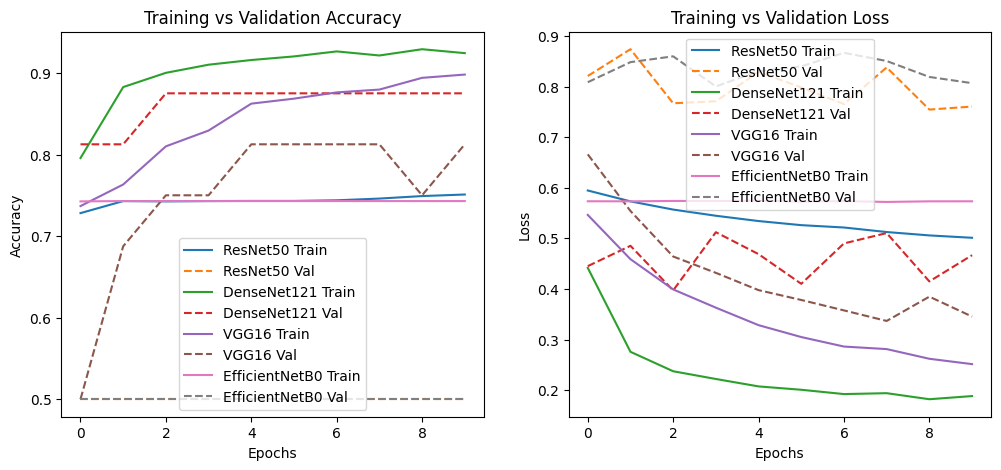


🔹 Evaluating ResNet50...

20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step


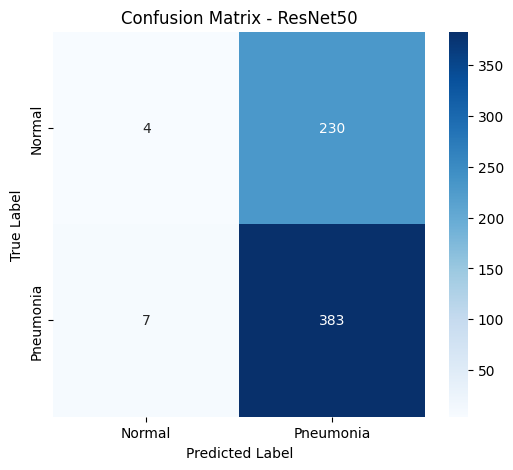

Classification Report - ResNet50:

              precision    recall  f1-score   support

      Normal       0.36      0.02      0.03       234
   Pneumonia       0.62      0.98      0.76       390

    accuracy                           0.62       624
   macro avg       0.49      0.50      0.40       624
weighted avg       0.53      0.62      0.49       624



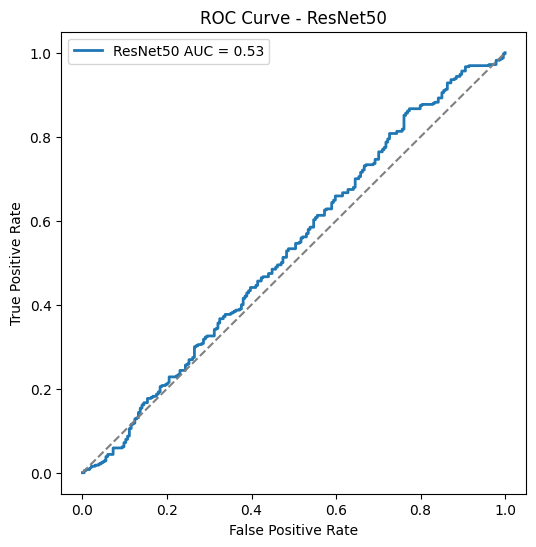


🔹 Evaluating DenseNet121...

20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step 


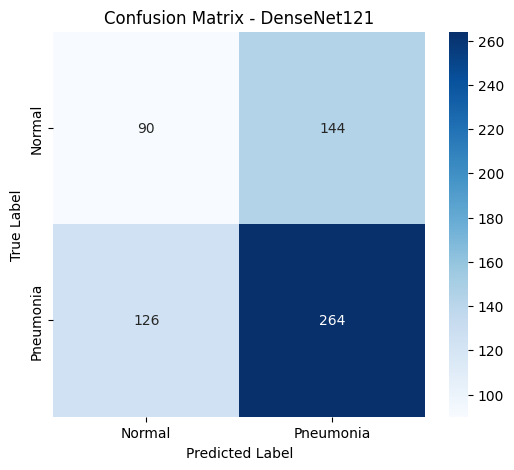

Classification Report - DenseNet121:

              precision    recall  f1-score   support

      Normal       0.42      0.38      0.40       234
   Pneumonia       0.65      0.68      0.66       390

    accuracy                           0.57       624
   macro avg       0.53      0.53      0.53       624
weighted avg       0.56      0.57      0.56       624



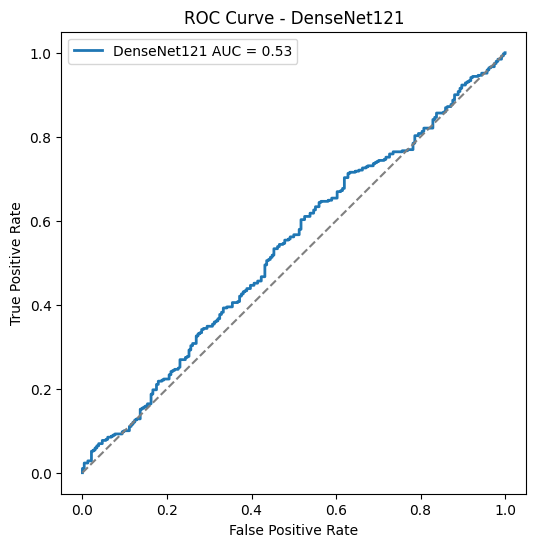


🔹 Evaluating VGG16...

20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


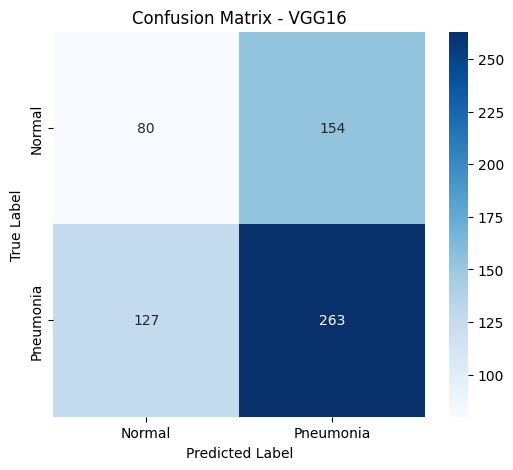

Classification Report - VGG16:

              precision    recall  f1-score   support

      Normal       0.39      0.34      0.36       234
   Pneumonia       0.63      0.67      0.65       390

    accuracy                           0.55       624
   macro avg       0.51      0.51      0.51       624
weighted avg       0.54      0.55      0.54       624



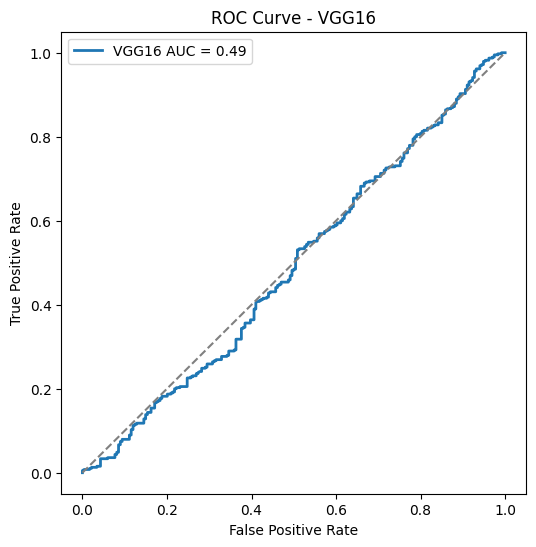


🔹 Evaluating EfficientNetB0...

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 601ms/step


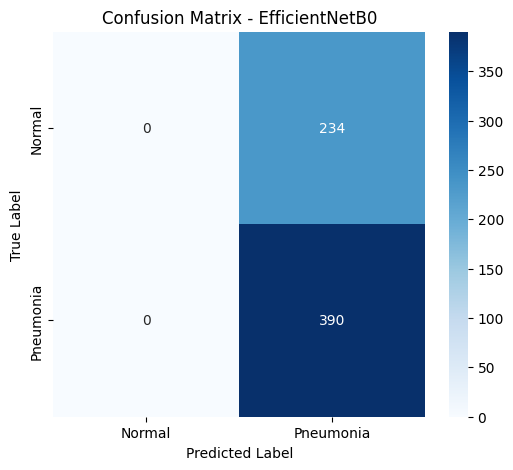

Classification Report - EfficientNetB0:

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00       234
   Pneumonia       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



C:\Users\adars\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\adars\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\adars\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

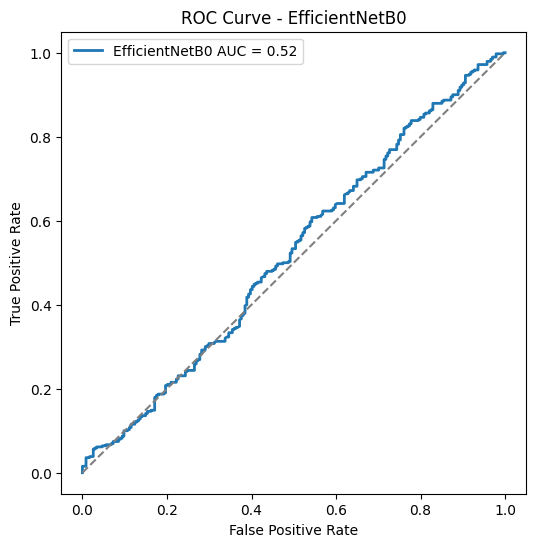

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# 📌 Plot Training vs Validation Accuracy & Loss for all models
def plot_training_history(history_dict):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    for model_name, history in history_dict.items():
        epochs = range(len(history.history['accuracy']))
        plt.plot(epochs, history.history['accuracy'], label=f"{model_name} Train")
        plt.plot(epochs, history.history['val_accuracy'], linestyle="dashed", label=f"{model_name} Val")
    
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    for model_name, history in history_dict.items():
        epochs = range(len(history.history['loss']))
        plt.plot(epochs, history.history['loss'], label=f"{model_name} Train")
        plt.plot(epochs, history.history['val_loss'], linestyle="dashed", label=f"{model_name} Val")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    
    plt.show()

plot_training_history(history_dict)


# 📌 Confusion Matrix, Classification Report & ROC Curve for Each Model
class_labels = ["Normal", "Pneumonia"]

for model_name, model in models.items():
    print(f"\n🔹 Evaluating {model_name}...\n")
    
    y_true = test_generator.classes
    y_prob = model.predict(test_generator)  # Get probability scores
    y_pred = (y_prob > 0.5).astype("int32")  # Convert probabilities to 0 or 1

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Classification Report
    print(f"Classification Report - {model_name}:\n")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random guess line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.show()


{'ResNet50': <keras.src.callbacks.history.History object at 0x000001BDE644AF60>, 'DenseNet121': <keras.src.callbacks.history.History object at 0x000001BE40F100E0>, 'VGG16': <keras.src.callbacks.history.History object at 0x000001BE63F550D0>, 'EfficientNetB0': <keras.src.callbacks.history.History object at 0x000001BE64990530>}


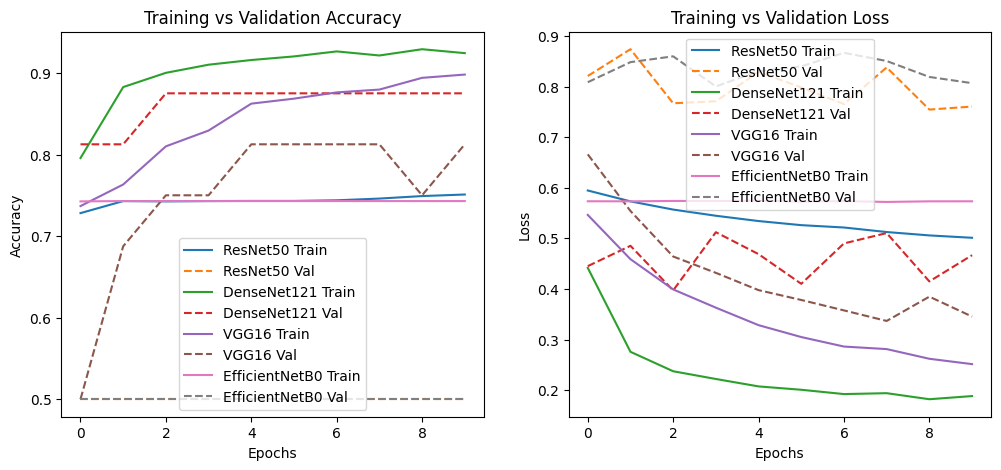

In [73]:
print(history_dict)  # Check if it's correctly populated
plot_training_history(history_dict)  # Call after verification


In [74]:
# Evaluate Individual Model Accuracies
test_accuracies = {}

for model_name, model in models.items():
    test_loss, test_acc = model.evaluate(test_generator)
    test_accuracies[model_name] = test_acc
    print(f"📊 {model_name} Test Accuracy: {test_acc * 100:.2f}%\n")

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 726ms/step - accuracy: 0.6407 - loss: 0.5731
📊 ResNet50 Test Accuracy: 63.30%

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 712ms/step - accuracy: 0.8925 - loss: 0.3111
📊 DenseNet121 Test Accuracy: 88.78%

20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8773 - loss: 0.3005
📊 VGG16 Test Accuracy: 86.70%

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 450ms/step - accuracy: 0.5951 - loss: 0.7141
📊 EfficientNetB0 Test Accuracy: 62.50%



## ENSEMBLE MODEL

In [3]:
from tensorflow.keras.models import load_model

# Load pre-trained models
resnet_model = load_model('ResNet50.h5')
densenet_model = load_model('DenseNet121.h5')
vgg16_model = load_model('VGG16.h5')
efficientnet_model = load_model('EfficientNetB0.h5')


## Defining Weighting Average for Ensemble

In [24]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
base_dir = "D:\\Project 2\\chest_xray"
test_dir = os.path.join(base_dir, "test")  # Test images path


test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Normalize images

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),  # Ensure the same size as during training
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Don't shuffle to maintain correct label order
)


# Generate predictions
resnet_preds = resnet_model.predict(test_generator)
densenet_preds = densenet_model.predict(test_generator)
vgg16_preds = vgg16_model.predict(test_generator)
efficientnet_preds = efficientnet_model.predict(test_generator)

Found 624 images belonging to 2 classes.


NameError: name 'resnet_model' is not defined

In [6]:
# Define model weights (higher for better models)
weights = [0.2, 0.4, 0.4, 0.2]  # Adjusted based on performance

# Compute weighted ensemble predictions
ensemble_preds = (
    weights[0] * resnet_preds +
    weights[1] * densenet_preds +
    weights[2] * vgg16_preds +
    weights[3] * efficientnet_preds
) / sum(weights)

# Convert probabilities to binary predictions (threshold = 0.5 for classification)
ensemble_preds = (ensemble_preds > 0.5).astype(int)

## Calculate Ensemble Accuracy

In [7]:
from sklearn.metrics import accuracy_score

# Get true labels from test_generator
true_labels = test_generator.classes  # Ground truth

# Compute accuracy
ensemble_accuracy = accuracy_score(true_labels, ensemble_preds)
print(f"🔥 Final Ensemble Model Accuracy: {ensemble_accuracy * 100:.2f}%")

🔥 Final Ensemble Model Accuracy: 87.66%


In [9]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.metrics import accuracy_score

# Define the dataset directory
base_dir = "D:\\Project 2\\chest_xray"
test_dir = os.path.join(base_dir, "test")

# Image augmentation for Test-Time Augmentation (TTA)
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Create a test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Generate predictions from each model
resnet_preds = resnet_model.predict(test_generator)
densenet_preds = densenet_model.predict(test_generator)
vgg16_preds = vgg16_model.predict(test_generator)
efficientnet_preds = efficientnet_model.predict(test_generator)

# Adjusted weights (higher for DenseNet121 & VGG16)
weights = [0.1, 0.45, 0.45, 0.1]

# Compute weighted ensemble predictions
ensemble_preds = (
    weights[0] * resnet_preds +
    weights[1] * densenet_preds +
    weights[2] * vgg16_preds +
    weights[3] * efficientnet_preds
) / sum(weights)

# Soft Voting: Keep as probabilities instead of binary conversion
final_preds = (ensemble_preds > 0.5).astype(int)

# Get true labels from test generator
true_labels = test_generator.classes

# Compute accuracy
ensemble_accuracy = accuracy_score(true_labels, final_preds)
print(f"🚀 Optimized Ensemble Model Accuracy: {ensemble_accuracy * 100:.2f}%")


Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step
🚀 Optimized Ensemble Model Accuracy: 85.26%


In [25]:
import tensorflow as tf

model = tf.keras.models.load_model("pneumonia_cnn_model.h5")
print(model.input_shape)  # Check expected input shape


(None, 150, 150, 3)
